In [1]:
using LinearAlgebra
using Distributions
using NearestNeighbors
using Random
using StatsPlots
using QuadGK

Random.seed!(4);
gr();

In [2]:
function simulate(thetas)
    # one simulation for each theta
    return rand.(Binomial.(1, thetas))
end

simulate (generic function with 1 method)

In [3]:
function gaussian_kernel(evaluation_point, mean, width)
    return exp(-(evaluation_point - mean)^2/width^2)
end

function gaussian_kernel_average(evaluation_points, simulated_thetas, sim_results, width)
    
    kernel_weights = gaussian_kernel.(evaluation_points, simulated_thetas', width)
    kernel_importance = kernel_weights*ones(length(simulated_thetas))
    kernel_acceptance = kernel_weights*sim_results
    return kernel_acceptance./kernel_importance
end


function gaussian_kernel_estimate(simulated_thetas, sim_results; width = -1, num_gauss_points = 20, f = x -> x, prior = Uniform(0,1), importance_distribution = nothing)
    # importance distribution not used, just want same arguments as rejection estimate
    if width < 0
        width = sqrt(length(simulated_thetas))^(-1)
    end
    evaluation_points, evaluation_weights = gauss(num_gauss_points, 0, 1)
    
    likelihood_estimates = gaussian_kernel_average(evaluation_points, simulated_thetas, sim_results, width)
    
    prior_pdf = x -> pdf(prior, x)
    return (dot(evaluation_weights, (prior_pdf.(evaluation_points)) .* likelihood_estimates .* (f.(evaluation_points)))/
            dot(evaluation_weights, (prior_pdf.(evaluation_points)) .* likelihood_estimates))
end

gaussian_kernel_estimate (generic function with 1 method)

In [4]:
function rejection_estimate(simulated_thetas, sim_results; importance_distribution = Uniform(0,1), f = x -> x, prior = Uniform(0,1))
    weights = sim_results .* (pdf.(prior, simulated_thetas)) ./ (pdf.(importance_distribution, simulated_thetas))
    return dot(f.(simulated_thetas), weights) / sum(weights)
end

rejection_estimate (generic function with 1 method)

In [5]:
threshold = 0.5
test_function = x -> (x < threshold)
true_mean = cdf(Beta(2,1), threshold)
println(true_mean)


0.25


In [6]:
function test_estimators(estimator_functions; samples_range = 2 .^ (2:10), num_trials = 1000, importance_distribution = Uniform(0,1), prior_params = [1,1], f = x -> x)
    prior = Beta(prior_params[1], prior_params[2])
    estimated_means = -1*ones(length(estimator_functions), length(samples_range), num_trials)
    for j in 1:length(samples_range)
        N = samples_range[j]
        for trial in 1:num_trials
            simulated_thetas = rand(importance_distribution, N)
            sim_results = simulate(simulated_thetas)
            for i in 1:length(estimator_functions)
                estimated_means[i, j, trial] = estimator_functions[i](simulated_thetas, sim_results, prior = prior, f = f, importance_distribution = importance_distribution)
            end
        end
    end    
    return estimated_means
end

test_estimators (generic function with 1 method)

In [7]:
all_estimated_means = Dict()

Dict{Any,Any} with 0 entries

### Sampling from the prior

In [8]:
samples_range = [1000]
@time all_estimated_means["Prior"] = test_estimators([rejection_estimate, gaussian_kernel_estimate],
                                        samples_range = samples_range,
                                        f = test_function);

  2.581048 seconds (7.56 M allocations: 522.069 MiB, 5.60% gc time)


### Sampling from the posterior

In [9]:
@time all_estimated_means["Posterior"] = test_estimators([rejection_estimate, gaussian_kernel_estimate],
    samples_range = samples_range,
    importance_distribution = Beta(2,1),
    f = test_function
    );

  1.732809 seconds (2.89 M allocations: 287.318 MiB, 3.19% gc time)


### Sampling for high ESS

Using the geometric mean between posterior and prior. Here the posterior is Beta(2,1) and the prior is Beta(1,1). Their geometric mean is Beta(1.5,1).

In [10]:
@time all_estimated_means["Optimized\nfor ESS"] = test_estimators([rejection_estimate, gaussian_kernel_estimate],
    samples_range = samples_range,
    importance_distribution = Beta(1.5,1),
    f = test_function
    );

  1.264370 seconds (1.65 M allocations: 225.144 MiB, 2.13% gc time)


### Sampling from densities targeted at our test function

In [11]:
targeted_stratified_dist = MixtureModel([truncated(Beta(1.5, 1.5), 0, 1/2),
                          truncated(Beta(1.5, 1.5), 1/2, 1)],
                        [0.75, 0.25]
                        )

targeted_independent_dist = MixtureModel([truncated(Beta(1.5, 1),0,1/2),
                          truncated(Beta(1.5, 1),1/2, 1)],
                        normalize([2^(-5/2), (1-2^(-3/2))/6], 1) # weights calculated by hand 
                        )

MixtureModel{Truncated{Beta{Float64},Continuous,Float64}}(K = 2)
components[1] (prior = 0.6213): Truncated(Beta{Float64}(α=1.5, β=1.0), range=(0.0, 0.5))
components[2] (prior = 0.3787): Truncated(Beta{Float64}(α=1.5, β=1.0), range=(0.5, 1.0))


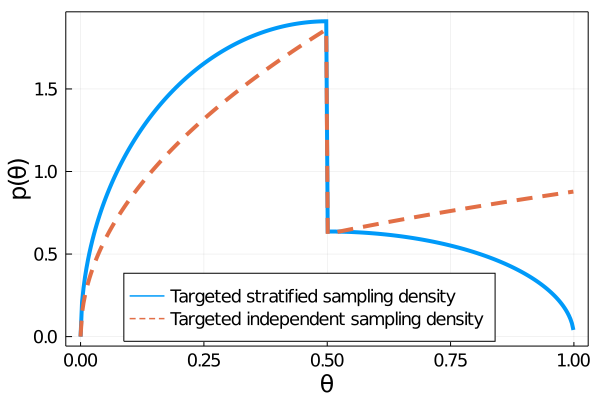

In [12]:
legendfontsize = 12
tickfontsize = 12
labelfontsize = 16
plot_thetas = 0:0.003:1

p = plot(plot_thetas, pdf.(targeted_stratified_dist, plot_thetas), label = "Targeted stratified sampling density", linewidth = 4)
plot!(plot_thetas, pdf.(targeted_independent_dist, plot_thetas), label = "Targeted independent sampling density", linewidth = 4, linestyle = :dash)


plot!(framestyle = :box, xlabel = "θ", ylabel = "p(θ)", legend = (0.2, 0.15),
    yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
    xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
)

In [13]:
# sampling independently from the distribution designed for stratified sampling
@time all_estimated_means["Designed for\nstratified"] = test_estimators([rejection_estimate, gaussian_kernel_estimate],
    samples_range = samples_range,
    importance_distribution = targeted_stratified_dist,
    f = test_function
    );

  3.216156 seconds (10.06 M allocations: 416.769 MiB, 3.27% gc time)


In [14]:
@time all_estimated_means["Optimized for\nindependent"] = test_estimators([rejection_estimate, gaussian_kernel_estimate],
    samples_range = samples_range,
    importance_distribution = targeted_independent_dist,
    f = test_function
    );

  2.886513 seconds (9.15 M allocations: 370.149 MiB, 2.73% gc time)


### Stratified sampling

In [15]:
function inverse_cdf(dist, point, tol = 10^-5)
    current_min = 0
    current_max = 1
    current_val = 0.5
    while (current_max - current_min) > tol
        current_val = (current_max + current_min)/2
        cdf_val = cdf(dist, current_val)
        if cdf_val > point
            current_max = current_val
        else
            current_min = current_val
        end
    end
    return current_val
end

inverse_cdf (generic function with 2 methods)

In [16]:
function test_estimators_stratified(estimator_functions; samples_range = 2 .^ (2:10), num_trials = 1000, importance_distribution = Uniform(0,1), prior_params = [1,1], f = x -> x)
    prior = Beta(prior_params[1], prior_params[2])
    estimated_means = -1*ones(length(estimator_functions), length(samples_range), num_trials)
    for j in 1:length(samples_range)
        N = samples_range[j]
        simulated_thetas = inverse_cdf.(importance_distribution, (0:(1/N):(1 - 1/N)) + rand(N)/N)
        for trial in 1:num_trials
            sim_results = simulate(simulated_thetas)
            for i in 1:length(estimator_functions)
                estimated_means[i, j, trial] = estimator_functions[i](simulated_thetas, sim_results, prior = prior, f = f, importance_distribution = importance_distribution)
            end
        end
    end    
    return estimated_means
end

test_estimators_stratified (generic function with 1 method)

In [17]:
@time all_estimated_means["Stratified"] = test_estimators_stratified([rejection_estimate, gaussian_kernel_estimate],
    samples_range = samples_range,
    importance_distribution = targeted_stratified_dist,
    f = test_function
    );

  2.135788 seconds (10.09 M allocations: 402.673 MiB, 4.71% gc time)


In [18]:
all_errors = Dict()
for key in keys(all_estimated_means)
    all_errors[key] = (all_estimated_means[key] .- true_mean).^2
end

### Plotting MSEs

In [19]:
all_mean_errors = [mean(all_errors[k][1,1,:]) for k in keys(all_errors)]
sorted_keys = [k for k in keys(all_errors)][sortperm(all_mean_errors, rev=true)]


6-element Array{String,1}:
 "Posterior"                 
 "Designed for\nstratified"  
 "Prior"                     
 "Optimized\nfor ESS"        
 "Optimized for\nindependent"
 "Stratified"                

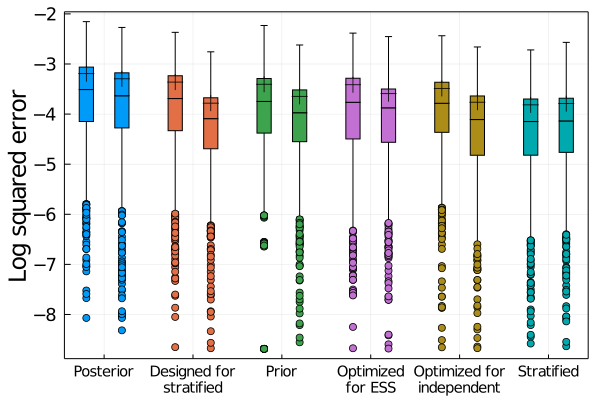

In [20]:
p = plot()

for (key, i) in zip(sorted_keys, 1:length(keys(all_errors)))
    boxplot!(repeat([5*i-1], outer = samples_range[1]), log10.(all_errors[key][1,1,:] .+ exp(-20)), label = key, color = i)
    boxplot!(repeat([5*i+1], outer = samples_range[1]), log10.(all_errors[key][2,1,:] .+ exp(-20)), label = nothing,color = i)
    
    scatter!([5*i - 1], [log10(mean(all_errors[key][1,1,:]))], label = nothing, color = :black, marker = (8, :cross))
    scatter!([5*i + 1], [log10(mean(all_errors[key][2,1,:]))], label = nothing, color = :black, marker = (8, :cross))
end



plot!(legend = nothing,
    ylabel = "Log squared error",
    xticks = (5:5:(5*length(all_errors)), sorted_keys),
    framestyle = :box,
    yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
    xguidefontsize = labelfontsize, xtickfontsize = tickfontsize-2,
)

### Comparing effective sample sizes and acceptance rates for each sampling strategy

In [21]:
function ess_per_sample(;importance_distribution = Uniform(0,1), prior = Uniform(0,1), num_samples = 1000)
    simulated_thetas = rand(importance_distribution, num_samples)
    sim_results = simulate.(simulated_thetas)
    weights = sim_results .* (pdf.(prior, simulated_thetas)) ./ (pdf.(importance_distribution, simulated_thetas))
    
    return sum(weights)^2/sum(weights.^2)/num_samples
end

function ess_per_sample_distribution(;importance_distribution = Uniform(0,1), prior = Uniform(0,1), num_samples = 1000, num_trials = 10)
    return [ess_per_sample(importance_distribution = importance_distribution, prior = prior, num_samples = num_samples) for i in 1:num_trials]
end


function acceptances_per_sample(;importance_distribution = Uniform(0,1), num_samples = 1000)
    simulated_thetas = rand(importance_distribution, num_samples)
    sim_results = simulate.(simulated_thetas)    
    return sum(sim_results)/num_samples
end

function acceptances_per_sample_distribution(;importance_distribution = Uniform(0,1), num_samples = 1000, num_trials = 10)
    return [acceptances_per_sample(importance_distribution = importance_distribution, num_samples = num_samples) for i in 1:num_trials]
end


acceptances_per_sample_distribution (generic function with 1 method)

In [22]:
num_trials = 1000
@time ess_samples = hcat(ess_per_sample_distribution(importance_distribution = Uniform(0,1), num_trials = num_trials),
    ess_per_sample_distribution(importance_distribution = Beta(2,1), num_trials = num_trials),
    ess_per_sample_distribution(importance_distribution = targeted_independent_dist, num_trials = num_trials),
    ess_per_sample_distribution(importance_distribution = targeted_stratified_dist, num_trials = num_trials),
    ess_per_sample_distribution(importance_distribution = Beta(1.5,1), num_trials = num_trials),
    )

# ess per sample given for 
# prior sampling, posterior sampling, targeted independent sampling, targeted stratified sampling, and max-ESS sampling
vcat(mean(ess_samples, dims = 1), std(ess_samples, dims = 1)/sqrt(num_trials))

  5.235248 seconds (17.26 M allocations: 554.876 MiB, 3.12% gc time)


2×5 Array{Float64,2}:
 0.499951     0.513354    0.431415     0.241559     0.562757   
 0.000496281  0.00190157  0.000473313  0.000978589  0.000551205

In [23]:
num_trials = 1000
@time acceptances_samples = hcat(acceptances_per_sample_distribution(importance_distribution = Uniform(0,1), num_trials = num_trials),
    acceptances_per_sample_distribution(importance_distribution = Beta(2,1), num_trials = num_trials),
    acceptances_per_sample_distribution(importance_distribution = targeted_independent_dist, num_trials = num_trials),
    acceptances_per_sample_distribution(importance_distribution = targeted_stratified_dist, num_trials = num_trials),
    acceptances_per_sample_distribution(importance_distribution = Beta(1.5,1), num_trials = num_trials),
    )

# acceptance rate per sample given for 
# prior sampling, posterior sampling, targeted independent sampling, targeted stratified sampling, and max-ESS sampling
vcat(mean(acceptances_samples, dims = 1), std(acceptances_samples, dims = 1)/sqrt(num_trials))

  2.903199 seconds (532.07 k allocations: 103.793 MiB, 0.95% gc time)


2×5 Array{Float64,2}:
 0.499598     0.666208     0.476148     0.394343     0.6002     
 0.000491092  0.000485914  0.000508866  0.000481218  0.000499565